# 1. Introduction

Breast cancer is a type of cancer that develops in the breast tissue. It is one of the most common types of cancer in women, and it can also occur in men, although it is much less common. The breast cancer dataset contains 4024 observations with 16 feature columns.

The main aim of this notebook is to perform data analysis to identify the relationship between features and predict the status of patients diagnosed with breast cancer.

**Data Description:**
The information about some technical terms present in the dataset such as `T Stage`, `N Stage`, and `6th Stage` etc. can be found here: https://ieee-dataport.org/open-access/seer-breast-cancer-data



# 2. Setup

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline

# Metrics
from sklearn.metrics import recall_score, accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Counter
from collections import Counter

# Color definition
class color:
    BOLD = '\033[1m'
    END = '\033[0m'

# Read the data
df = pd.read_csv("/kaggle/input/breast-cancer/Breast_Cancer.csv")
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


# 3. EDA

In [2]:
# Renaming some column names
df.rename({'Tumor Size' : 'Tumor Size (mm)', 'T Stage ': 'T Stage', 'Reginol Node Positive' : 'Regional Node Positive', 'differentiate' : 'Differentiate'}, axis=1, inplace=True)

# Changinge the values of 'Grade' column to uniform values
df['Grade'] = df['Grade'].map({'1' : 'Grade 1', '2' : 'Grade 2', '3' : 'Grade 3', ' anaplastic; Grade IV' : 'Grade 4'})

In [3]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   Differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size (mm)         4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Regional Node Positive  4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

## 3.1 Dealing with Outliers

The boxplot visualizations of some numerical features like `Tumor Size`, `Regional Node Examined`, `Regional Node Positive`, and `Survival Months` indicate that some data points are significantly different from other observations. With the "IQR method", the outliers are identified for the above-mentioned columns. The total number of outliers is 617, approximately 15% of the total observations. As the dataset contains only 4024 rows, removing 15% of the row values may significantly affect the final predictions. Hence the outliers are not removed for machine learning modeling.

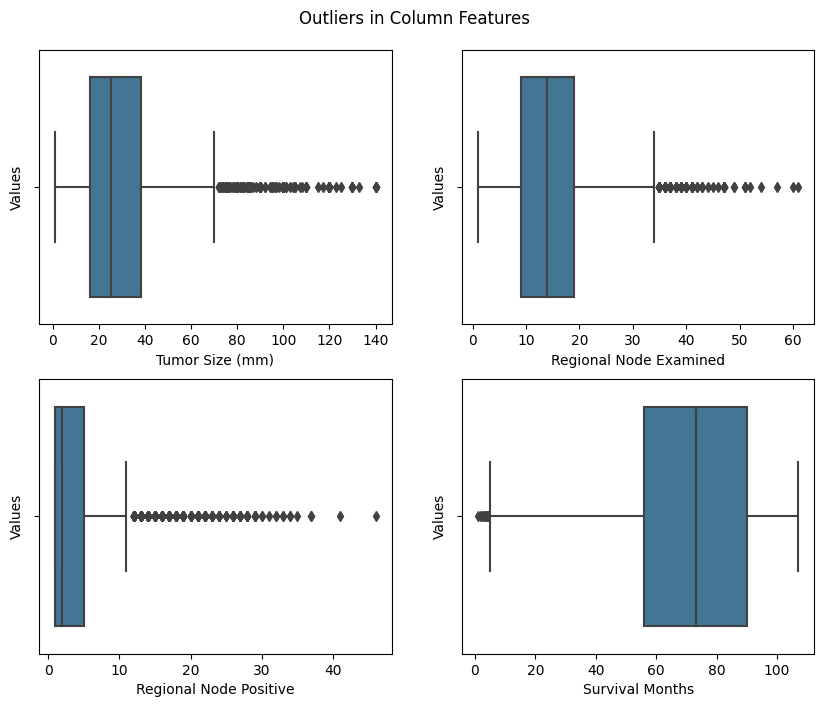

In [4]:
# Box plot to identify the outliers in columns
num_cols = ['Tumor Size (mm)', 'Regional Node Examined', 'Regional Node Positive', 'Survival Months']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8), dpi=100)
fig.suptitle('Outliers in Column Features', y = 0.93);
for col, ax in zip(num_cols, axes.ravel()):
    sns.boxplot(data=df, x=col, palette='mako_r', ax=ax)
    ax.set_ylabel('Values')

In [5]:
# Finding out the number of outliers based on "IQR" Method

outlier_cols = ['Tumor Size (mm)', 'Regional Node Examined', 'Regional Node Positive']

outlier_index = []
outlier_ind_list=[]

for col in outlier_cols:
    
    Q1 = np.percentile(df[col], 25, interpolation='midpoint')
    Q3 = np.percentile(df[col], 75, interpolation='midpoint')
    
    IQR = Q3 - Q1
    
    upper_bound = Q3 + (1.5 * IQR)
    lower_bound = Q1 - (1.5 * IQR)
    
    upper_outliers = df[col] >= upper_bound
    lower_outliers = df[col] <= lower_bound
    
    outliers = df[upper_outliers | lower_outliers].index
    
    outlier_index.extend(outliers)
    
# Outlier index with count
outlier_index = Counter(outlier_index)

# Storing only unique outlier index
for key in outlier_index.keys():
    outlier_ind_list.append(key)

# Dropping rows containing outliers
#df = df.drop(outlier_ind_list)

print(color.BOLD + f'Number of outliers: {len(outlier_ind_list)}' + color.END)

Number of outliers: 617


## 3.2 Data Analysis

The first column in the dataset is the `Age` column. The age of female patients ranges between 30 and 69. The average age of a patient is 53.97. <br>

The patients are further classified under the `Race` and `Marital Status` categories. There are three races identified from the patients: White, Black, and Other. Most of the patients fall under the category of White race whereas few patients are identified as either Black or Other. <br> 

The patient's relationship with their significant other is classified as Married, Single, Divorced, Widowed, and Separated. The majority of patients diagnosed with cancer are married. <br>

The `T Stage` describes the size of the tumor. There are four categories under the `T Stage` feature. 44.4% of patients are diagnosed with category T2, which corresponds to a tumor size between 20mm and 50mm. This is followed by T1, T3, and T4 with shares of 39.8%, 13.3%, and  2.5% respectively. <br>

The `N Stage` represents the extent to which cancer spread to lymph nodes. It has three categories: N1, N2, and N3. About 68% of the patients are in the N1 Stage which means cancer has spread to 1 to 3 axillary (underarm) lymph node(s), and/or cancer is found in internal mammary lymph nodes. <br>

The `6th Stage` column relates to the stage grouping for breast cancer. This stage group is based on the combination of T Stage, N Stage, and M Stage(Metastasis - which is not available in the dataset). The five categories of the `6th Stage` column and their proportions in the dataset are IIA (32.4%), IIB (28.1%), IIIA (26.1%), IIIC (11.7%), and IIIB (1.7). 

The `Differentiate` or `Grade` column tells us how well the tumor resembles the normal tissue. 
* Grade I - Well differentiated (found in 13.5% of the patients)
* Grade II - Moderately differentiated (58.4%)
* Grade III - Poorly differentiated (27.6%)
* Grade IV - Undifferentiated (anaplastic) (0.5%)

Column `A Stage` is also a categorical feature that contains two classes: Regional and Distant. Regional means the spread of cancer is localized. On the other hand, Distant corresponds to the spread of cancer to distant parts of the body such as the liver, lungs, or bones. Nearly 98% of the cancer spread is Regional class and only 2% is Distant class.

`Tumor Size (mm)` describes the size of a tumor in mm. The average size is 30.47 whereas the minimum and maximum size of the tumor are 1 and 140 mm respectively.

For the `Survival Months` numerical column, the average value is 71.3 months. The range of this column is between 1 and 107.


In [6]:
# Statistics for numerical columns
df.describe()

,Age,Tumor Size (mm),Regional Node Examined,Regional Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


**Imbalanced target class:** The count plot displays the percentage of patients belonging to the `Alive` and `Dead` classes. It is also important to note that the given dataset is highly imbalanced. Only 15% of the data belongs to the `Dead` class and the remaining belong to the `Alive` class. Since most of the data points are associated with the `Alive` class, there is a high chance that the machine learning models may be biased towards that class and could lead to poor performance for the `Dead` class. To overcome this imbalanced class problem, we could perform Random Oversampling or SMOTE analysis.

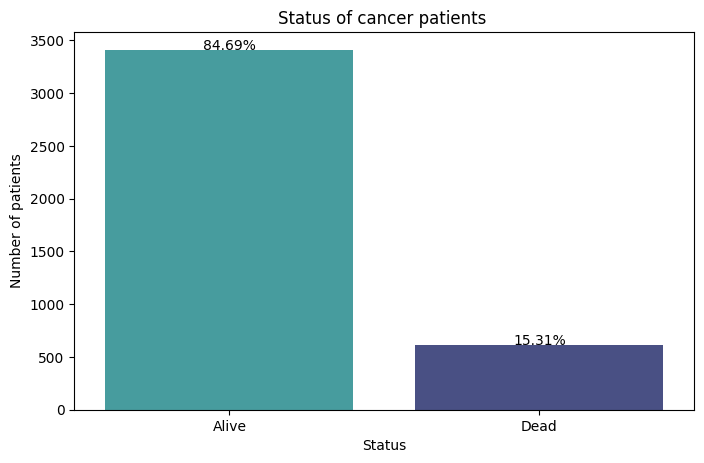

In [7]:
# Alive or Dead - Countplot
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
sns.countplot(data=df, x='Status', palette='mako_r')
ax.set_xlabel("Status")
ax.set_ylabel("Number of patients")
ax.set_title("Status of cancer patients ")
percentage = round(df['Status'].value_counts() * 100 /len(df), 2)
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.2f}%'.format(percentage[i]), (x, y), ha='center')

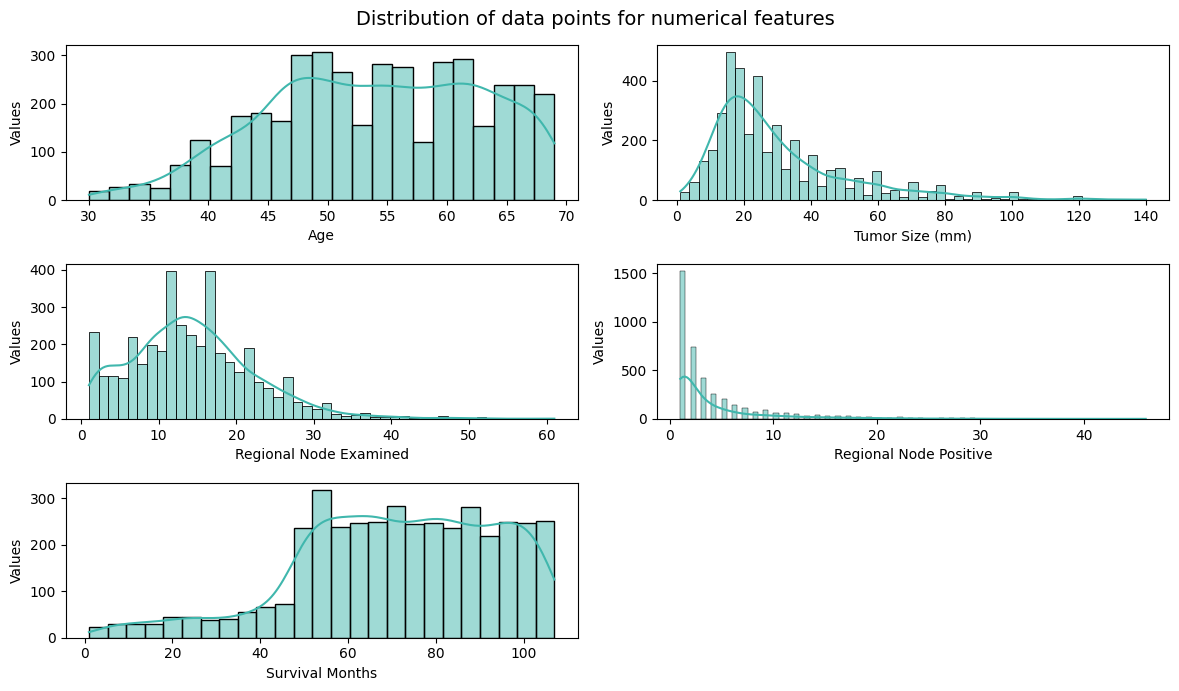

In [8]:
# Distribution of numerical features
skew_cols = df.select_dtypes(exclude='object').skew(axis=0).index

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,7), dpi=100)
fig.suptitle('Distribution of data points for numerical features', fontsize=14)
pal = sns.color_palette('mako_r')

for col, ax in zip(skew_cols, axes.ravel()):
    sns.histplot(data=df, x=col, kde='True', color=pal.as_hex()[1], ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Values')
fig.tight_layout()
fig.delaxes(axes[2,1])

* The distribution of values for numerical features is illustrated with the help of histplot. From the histplot, the `Age` column has a skewness of -0.22. Columns such as `Tumor Size` and `Regional Node Positive` are highly skewed towards the right side whereas `Regional Node Examined` and `Survival Months` columns are moderately skewed. The heatmap visualization highlights the weak correlation between numerical features.

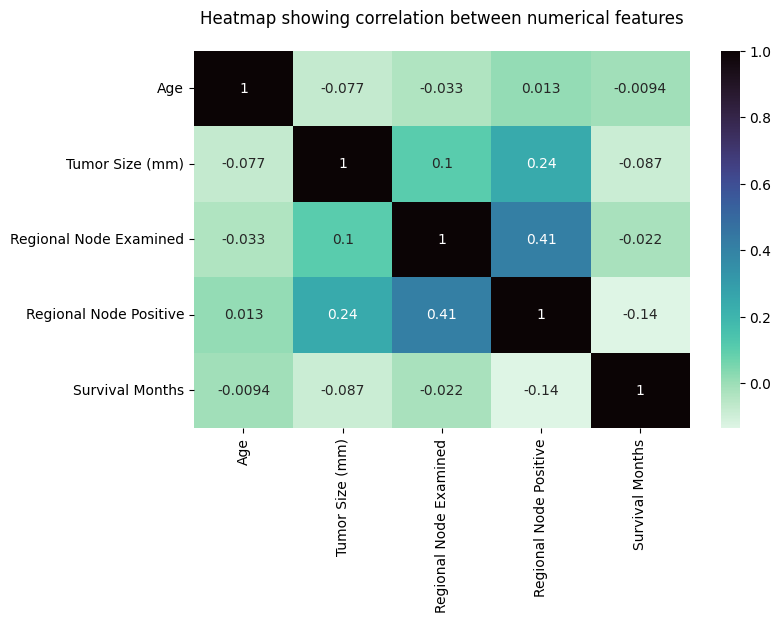

In [9]:
# Heatmap for numerical column correlation
plt.figure(figsize=(8,5), dpi=100)
sns.heatmap(df.corr(), annot=True, cmap='mako_r')
plt.title('Heatmap showing correlation between numerical features', y=1.05);

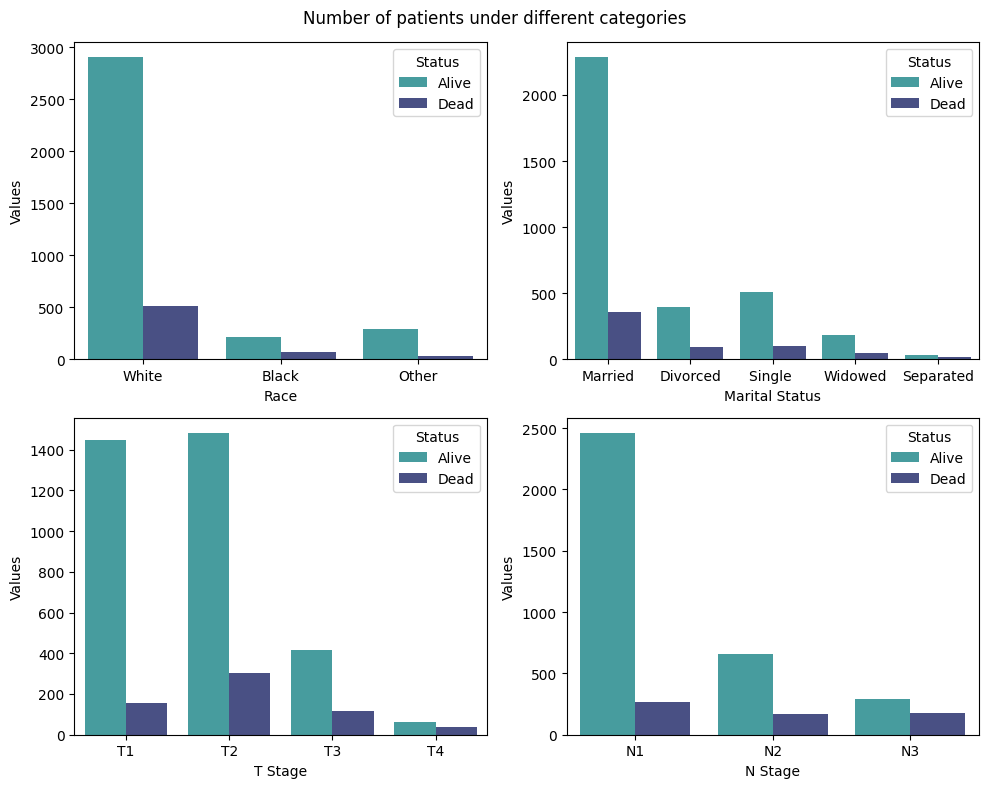

In [10]:
# Patients count for different categories
count_cols = ['Race', 'Marital Status', 'T Stage', 'N Stage']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8), dpi=100)
fig.suptitle('Number of patients under different categories', y = 0.98);
for col, ax in zip(count_cols, axes.ravel()):
    sns.countplot(data=df, x=col, hue='Status', palette='mako_r', ax=ax)
    ax.set_ylabel('Values')
    
plt.tight_layout()

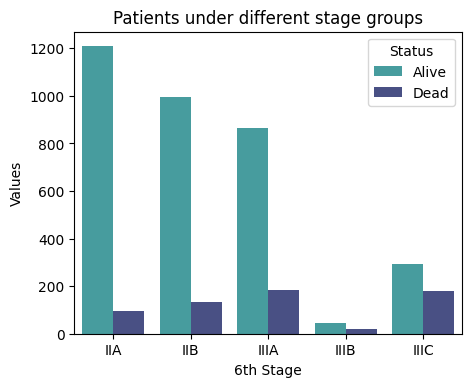

In [11]:
order_stage = ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC']

plt.figure(figsize=(5, 4), dpi=100)
sns.countplot(data=df, x='6th Stage', hue='Status', palette='mako_r', order=order_stage)
plt.ylabel('Values')
plt.title('Patients under different stage groups');

* The number of dead patients is less for each category under the `6th Stage` feature. Most of the patients in stage groups IIA, IIB, and IIIA survived.

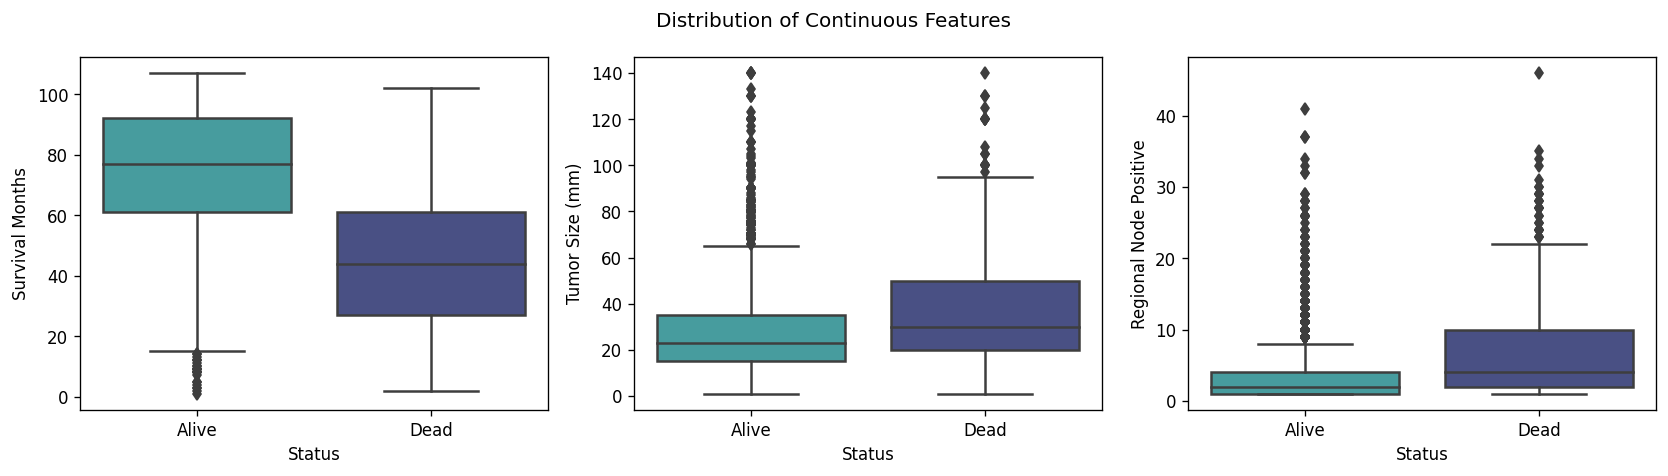

In [12]:
# Boxplot to visualize distribution of survival months and tumor size
box_cols = ['Survival Months', 'Tumor Size (mm)', 'Regional Node Positive']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4), dpi=120)
fig.suptitle('Distribution of Continuous Features', y = 0.98);
for col, ax in zip(box_cols, axes.ravel()):
    sns.boxplot(data=df, x='Status', y=col, palette='mako_r', ax=ax)
plt.tight_layout()


* Patients who survived have higher survival months compared to patients who died due to shorter survival months. Patients who survived breast cancer has small tumor size compared to those who died. However, there are few patients with large tumor size managed to survive.
<br><br>
* The regional node examined records the exact number of regional nodes that were removed and examined by the pathologist. The positive regional node records the exact number of regional lymph nodes examined by the pathologist that were found to contain metastases. The boxplot reveals that the patients who died had cancer spread to other parts of the body (metastatis).

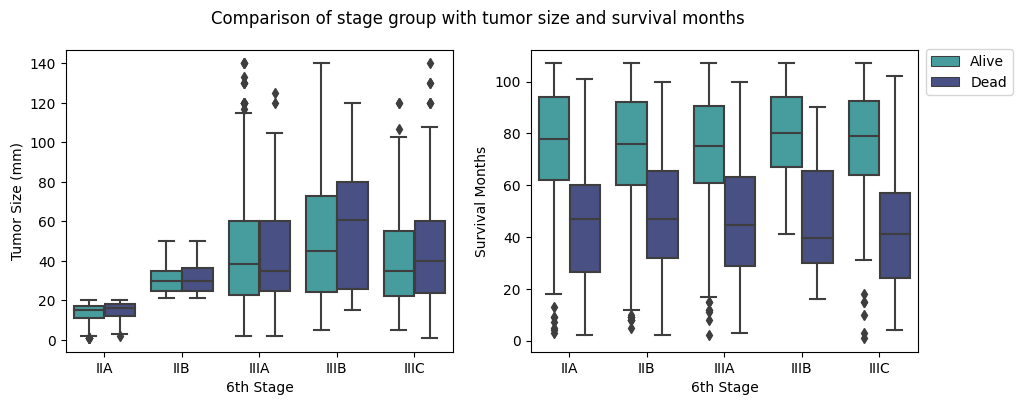

In [13]:
stage_cols = ['Tumor Size (mm)', 'Survival Months']
order_stage = ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4), dpi=100)
fig.suptitle('Comparison of stage group with tumor size and survival months', y = 0.98);
for col, ax in zip(stage_cols, axes.ravel()):
    sns.boxplot(data=df, x='6th Stage', y=col, hue='Status', order=order_stage, palette='mako_r', ax=ax)
    ax.legend_.remove()
ax.legend(loc=(1.02, 0.85));

* There are five stage-grouping categories under the `6th Stage` feature. The tumor size varies for different stage groups. For each stage, the tumor size is more or less the same for both survived and dead patients. This shows that there isn't any difference in tumor size between alive and dead patients for a particular stage group. Also, the range of survival months remains nearly the same for all the surviving patients across different stage groupings. This pattern is also fairly the same for patients who died.

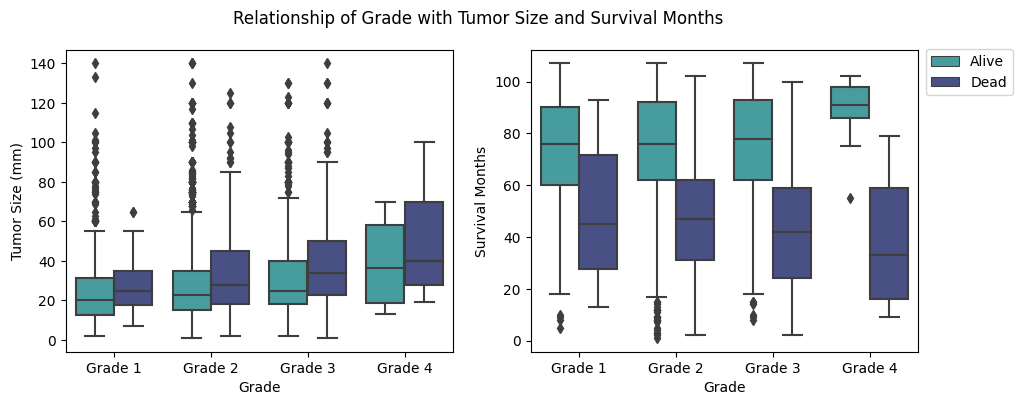

In [14]:
# Relationship of Grade with Tumor Size and Survival Months
grade_cols = ['Tumor Size (mm)', 'Survival Months']
grade_order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4), dpi=100)
fig.suptitle('Relationship of Grade with Tumor Size and Survival Months', y = 0.98);
for col, ax in zip(grade_cols, axes.ravel()):
    sns.boxplot(data=df, x='Grade', y=col, hue='Status', order=grade_order, palette='mako_r', ax=ax)
    ax.legend_.remove()
ax.legend(loc=(1.02, 0.85));

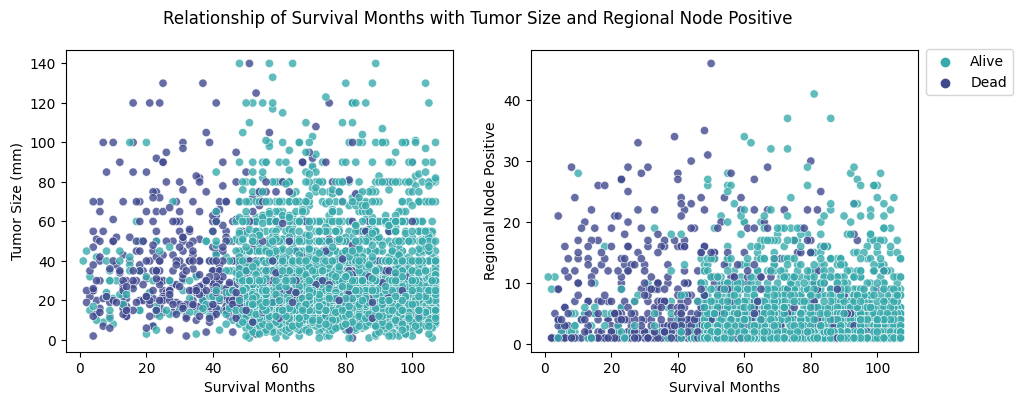

In [15]:
# Relationship of Survival Months with Tumor Size and Regional Node Positive
scatter_cols = ['Tumor Size (mm)', 'Regional Node Positive']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4), dpi=100)
fig.suptitle('Relationship of Survival Months with Tumor Size and Regional Node Positive', y = 0.98);
for col, ax in zip(scatter_cols, axes.ravel()):
    sns.scatterplot(data=df, x='Survival Months', y=col, hue='Status', palette='mako_r', ax=ax, alpha=0.8)
    ax.legend_.remove()
ax.legend(loc=(1.02, 0.85));

* Receptors are proteins in cells that can attach to certain substances in the blood. To make the best decision for treating breast cancer, a test is conducted to check for hormone receptor status. This hormone receptor status is either positive or negative based on the receptors that attach to estrogen and progesterone hormones. Cancer that has estrogen receptors is called Estrogen Positive and cancer that has progesterone receptors is called Progesterone Positive. The hormone receptor is positive if the estrogen or progesterone or both are positive. Otherwise, the hormone receptor is negative. For positive hormone receptors, hormone therapy drugs can be used to lower estrogen levels. Breast cancer cells with positive hormone receptor status grow slowly compared to cells with negative hormone receptor status. 


* To study the effect of `Hormone Receptor`, a new column named `Hormone Receptor Status` is created from the `Estrogen Status` and `Progesterone Status` columns. The count plot for the hormone receptor status reveals that the majority of the patients with positive hormone receptor survived.

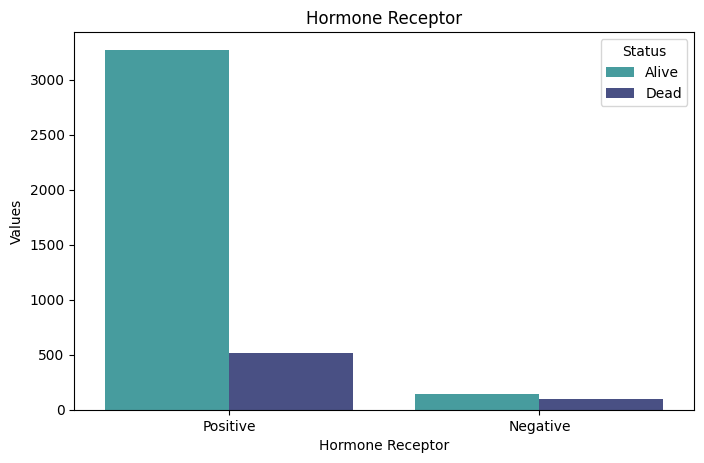

In [16]:
# Creating new feature column called 'Hormone Receptor' based on Estrogen and Progesterone Status
# if either Estrogen or Progesterone Status is Positive, then Hormone Receptor is Positive.
# otherwise, the Hormone Receptor is Negative
mask = (df['Estrogen Status'] == 'Positive') | (df['Progesterone Status'] == 'Positive')

conditions = [mask, ~mask]
values = ['Positive', 'Negative']

df['Hormone Receptor'] = np.select(conditions, values)

plt.figure(figsize=(8,5), dpi=100)
sns.countplot(data=df, x='Hormone Receptor', hue='Status', palette='mako_r')
plt.ylabel('Values')
plt.title('Hormone Receptor');

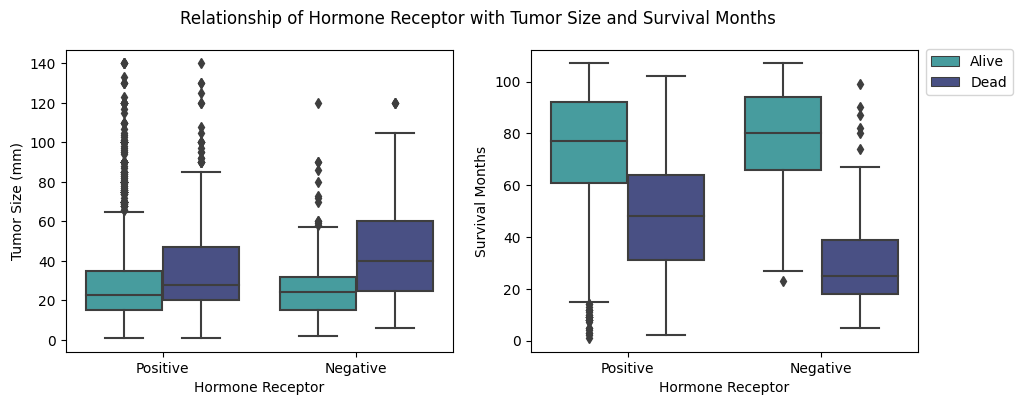

In [17]:
# Relationship of Hormone Receptor with Tumor Size and Survival Months
grade_cols = ['Tumor Size (mm)', 'Survival Months']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4), dpi=100)
fig.suptitle('Relationship of Hormone Receptor with Tumor Size and Survival Months', y = 0.98);
for col, ax in zip(grade_cols, axes.ravel()):
    sns.boxplot(data=df, x='Hormone Receptor', y=col, hue='Status', palette='mako_r', ax=ax)
    ax.legend_.remove()
ax.legend(loc=(1.02, 0.85));

## 3.3 Feature correlation with target label

* With the help of pandas dummy variables, the categorical feature variables are transformed into numerical variables in order to find out their correlation with the target label `Status`. <br>


* For `Status` that corresponds to 'Dead' class, there isn't any strong correlation. The correlated values range between -0.2 and +0.2.

In [18]:
df.sample(5, random_state=5)

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,Differentiate,Grade,A Stage,Tumor Size (mm),Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status,Hormone Receptor
1716,43,White,Married,T3,N2,IIIA,Undifferentiated,Grade 4,Regional,75,Negative,Negative,10,5,59,Dead,Negative
2383,65,White,Married,T1,N1,IIA,Poorly differentiated,Grade 3,Regional,2,Positive,Negative,10,1,32,Dead,Positive
3800,69,White,Married,T2,N1,IIB,Moderately differentiated,Grade 2,Regional,22,Positive,Positive,4,1,104,Alive,Positive
3192,68,White,Married,T2,N2,IIIA,Poorly differentiated,Grade 3,Regional,45,Positive,Positive,5,4,100,Alive,Positive
228,61,White,Divorced,T1,N1,IIA,Moderately differentiated,Grade 2,Regional,17,Positive,Positive,9,1,53,Alive,Positive


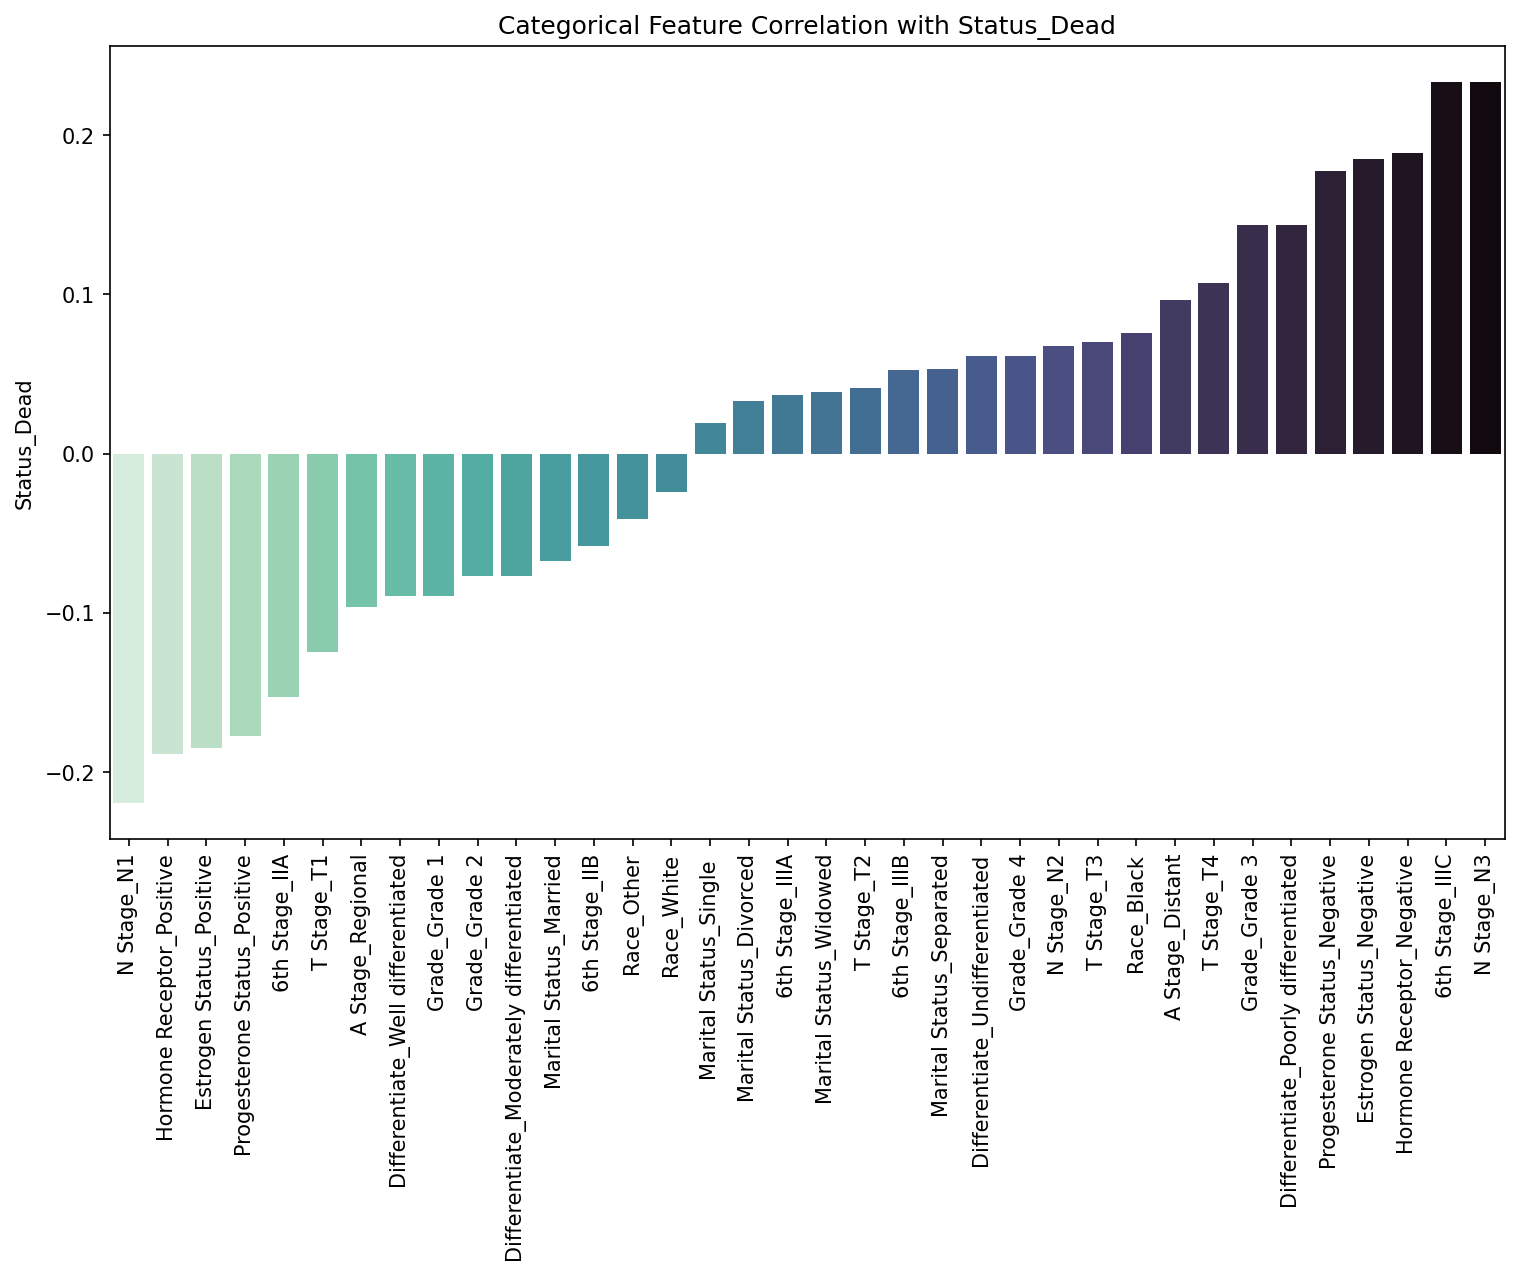

In [19]:
# Categorical Feature Correlation with Status_Dead
feature_obj_df = pd.get_dummies(df.select_dtypes('object'))

feature_obj_corr = feature_obj_df.corr().sort_values(by='Status_Dead')['Status_Dead'][1:-1]

feature_obj_corr = pd.DataFrame(feature_obj_corr).reset_index()

# Plot feature correlation with status_dead
plt.figure(figsize=(12,7), dpi=150)
sns.barplot(data=feature_obj_corr, x='index', y='Status_Dead', palette='mako_r')
plt.xticks(rotation=90)
plt.xlabel('')
plt.title("Categorical Feature Correlation with Status_Dead");

# 4. ML Models

* In this section, we will implement machine learning models to predict the target label (`Status`). For this purpose, we will select six models: Logistic Regression, Support Vector Classifier, Decision Tree Classifier, Random Forest Classifier, AdaBoost Classifier, and Gradient Boosting Classifier.


* Since the dataset is highly imbalanced, we will first test the models to predict the target variable for the imbalanced dataset. 



* Then we will apply Random Oversampling and SMOTE methods to increase the data points for the imbalanced class ("Dead") and evaluate the performance of the ML models on the modified dataset. 

In [20]:
# Random state
seed = 101

# For train dataset validation, choose kFold
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

# Class labels for target column
cls_labels = ['Alive', 'Dead']

# Model definition
cls_models = {'Logistic Regression' : LogisticRegression(max_iter=100000, random_state=seed), 
              'SVC' : SVC(max_iter=100000, random_state=seed), 
              'Decision Tree' : DecisionTreeClassifier(random_state=seed),
              'Random Forest' : RandomForestClassifier(random_state=seed), 'AdaBoost' : AdaBoostClassifier(random_state=seed), 
              'GradientBoosting' : GradientBoostingClassifier(random_state=seed)}

# Plot confusion matrix
def plot_confusion_matrix(models, y_test, y_pred_list, approach, rows, cols, w, h):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(w,h), dpi=100)
    fig.suptitle(f'Confusion Matrix for different models - {approach}', fontsize=14, y=0.97)
    for name, y_pred, ax in zip(models, y_pred_list, axes.ravel()):
        conf_mat = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, ax=ax, fmt='d', cmap='mako_r')
        ax.set_title(name)
        ax.set_xticklabels(cls_labels)
        ax.set_yticklabels(cls_labels)
    plt.tight_layout()
    plt.show()
        
    
# Baseline models - No oversampling
def run_baseline_models():
    
    accuracy_list = []
    recall_list = []
    precision_list = []
    
    for name, model in cls_models.items():
        
        score_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        score_precision = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision')
        score_recall = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall')        
        
        mean_accuracy_train = np.mean(score_accuracy.mean())
        mean_precision_train = np.mean(score_precision.mean())
        mean_recall_train = np.mean(score_recall.mean())
        
        accuracy_train.append(mean_accuracy_train)
        precision_train.append(mean_precision_train)
        recall_train.append(mean_recall_train)
        
        model.fit(X_train, y_train)
        
        # Predict target
        y_predict = model.predict(X_test)
        y_pred_baseline.append(y_predict)

        # Metrics
        accuracy_pred = accuracy_score(y_test, y_predict)
        precision_pred = precision_score(y_test, y_predict)
        recall_pred = recall_score(y_test, y_predict)
        
        accuracy_test.append(accuracy_pred)
        precision_test.append(precision_pred)
        recall_test.append(recall_pred)
        

## 4.1 Imbalanced classes - Baseline Models

* For the imbalanced dataset, six baseline classification ML models are used and the performance of each model is evaluated based on the accuracy, precision, and recall scores. The baseline models predict the `Alive` class with good accuracy but accuracy does not provide class-specific information. The prediction of values belonging to the `Dead` class is really poor. The recall scores on the train as well as test datasets are not yielding satisfactory results. This is because of the few observations from the minority class available for training the model. Hence accuracy is not a good indicator for the evaluation.



*  To increase the number of correct predictions for the `Dead` class, we need to improve the recall score which corresponds to the increase in the number of data points for the minority class (`Dead`). One approach is to use the random oversampling technique which duplicates data points from the minority class to balance the dataset. Another approach is to use Synthetic Minority Oversampling Technique (SMOTE) which uses the KNearest Neighbor algorithm to create synthetic points for the minority class.


* In this notebook, we will implement both random oversampling and SMOTE methods to balance the dataset and then analyze the model performance on the balanced dataset.

In [21]:
# Assign "0" to Alive class and "1" to Dead class
df['Status'] = df['Status'].map({'Alive' : 0, 'Dead' : 1}).astype('int64')

# Scaling the continuous feature variables with StandardScaler

new_df = df.copy()

num_cols = new_df.select_dtypes('int').columns

num_cols = num_cols[0:-1] # Not considering target column

scaler = StandardScaler()

scaled_numcols_df = pd.DataFrame(scaler.fit_transform(new_df[num_cols]), 
                                     columns=num_cols, index= new_df.index)

# Merging scaled data with the original dataframe
for col in num_cols:
    new_df[col] = scaled_numcols_df[col]
    
# Convert categorical string values to numeric values
X = pd.get_dummies(new_df.drop('Status', axis=1), drop_first=True)
y = df['Status']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

print(color.BOLD + f'Shape of X_train: {X_train.shape}' + color.END)
print(color.BOLD + f'Shape of X_test: {X_test.shape}' + color.END)

Shape of X_train: (2816, 30)
Shape of X_test: (1208, 30)


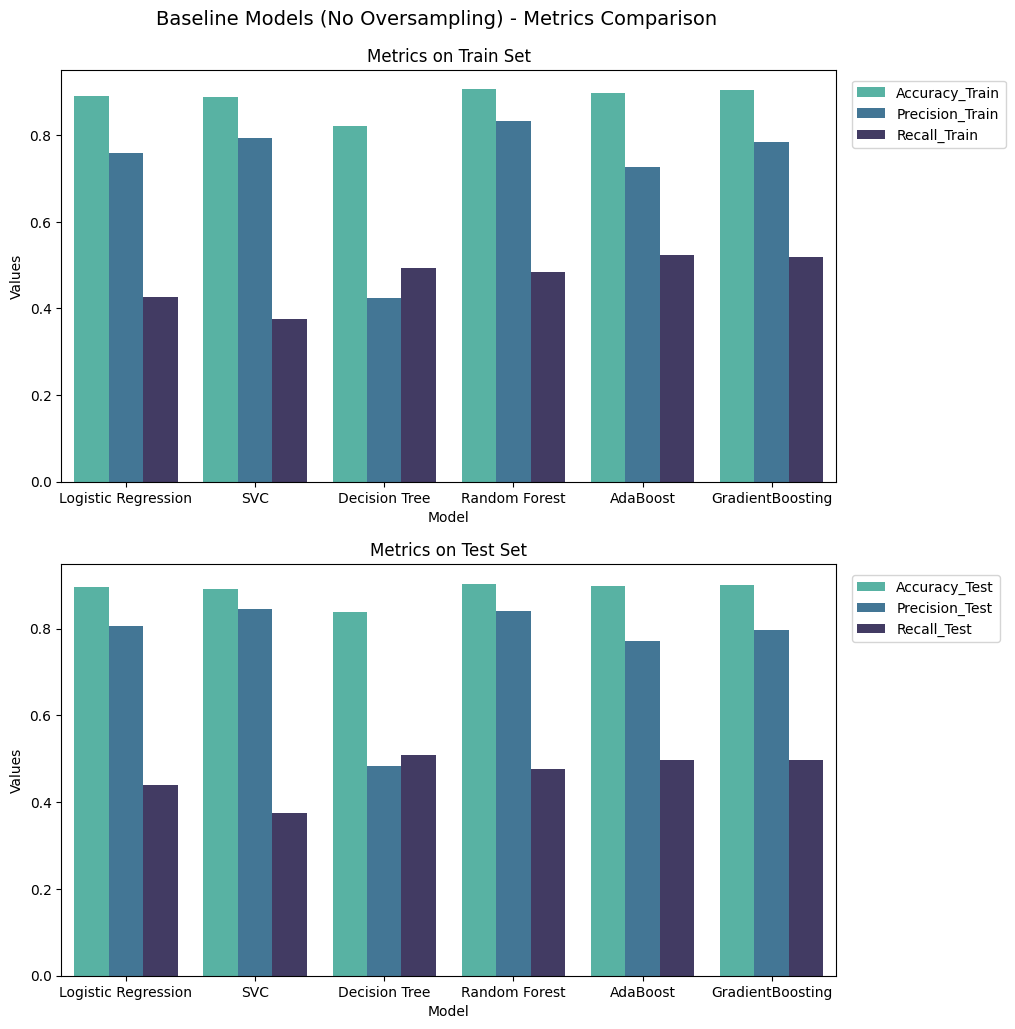

In [22]:
# Fit the baseline models on train set and predict target in test set
accuracy_train = []
precision_train = []
recall_train = []

accuracy_test = []
precision_test = []
recall_test = []

y_pred_baseline = []

# Run the baseline models
run_baseline_models()

# Store the metrics in a dataframe
metrics_base_train = pd.DataFrame(list(zip(cls_models.keys(), accuracy_train, 
                                           precision_train, recall_train)), 
                                  columns=['Model', 'Accuracy_Train', 'Precision_Train', 'Recall_Train'])

metrics_base_test = pd.DataFrame(list(zip(cls_models.keys(), accuracy_test, 
                                           precision_test, recall_test)), 
                                  columns=['Model', 'Accuracy_Test', 'Precision_Test', 'Recall_Test'])

metrics_melt_base_train = pd.melt(metrics_base_train, id_vars=['Model'], 
                                  value_vars=['Accuracy_Train', 'Precision_Train', 'Recall_Train'])

metrics_melt_base_test = pd.melt(metrics_base_test, id_vars=['Model'], 
                                 value_vars=['Accuracy_Test', 'Precision_Test', 'Recall_Test'])

# Plot the metrics
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), dpi=100)
fig.suptitle('Baseline Models (No Oversampling) - Metrics Comparison', fontsize=14, y=0.93)
sns.barplot(data=metrics_melt_base_train, x='Model', y='value', hue='variable', palette='mako_r', ax=ax1)
sns.barplot(data=metrics_melt_base_test, x='Model', y='value', hue='variable', palette='mako_r', ax=ax2)

ax1.set_ylabel('Values')
ax1.set_title('Metrics on Train Set')
ax1.legend(loc=(1.02, 0.81))

ax2.set_ylabel('Values')
ax2.set_title('Metrics on Test Set')
ax2.legend(loc=(1.02, 0.81));

* The bar plots visualize the metrics for the train and test sets for the baseline case (no oversampling). The accuracy obtained for the train and test sets is around 0.90. Even the precision values are better for most of the models except the decision tree model. Nonetheless, all the models fail to produce good recall scores. This is seen in the confusion matrix visualization shown below.

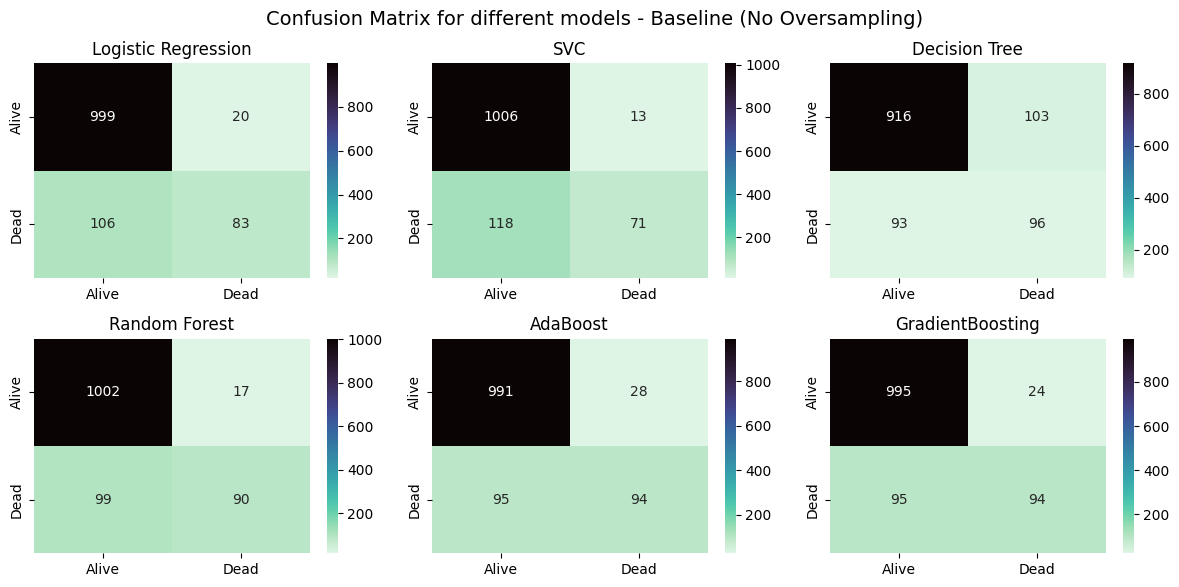

In [23]:
# Confusion matrix for different ML models for the imbalanced set
plot_confusion_matrix(cls_models, y_test, y_pred_baseline, 'Baseline (No Oversampling)', 2, 3, 12, 6)

## 4.3 Random Oversampling and SMOTE + ML Models

**NOTE:** Oversampling before validation would lead to oversampled model and cause overfitting. This allows for data leakage from the validation folds into the training folds. Instead, we should first split into training and validation folds. Then, on each fold, we should: 
    <br> <br>
  * Oversample the minority class
    <br> <br>
  * Train the classifier on the training folds
    <br> <br>
  * Validate the classifier on the remaining fold
    <br> 

In [24]:
# To implement the above steps, we will use a pipeline from imbalanced-learn library.

# Function definition
def run_sampling_model(estimator, method):
    
    cv = kfold
    
    accuracy_list = []
    recall_list = []
    precision_list = []
    
    sampling_params = {'sampling_strategy' : 'auto', 'random_state' : seed}
    
    if method == 'RandomOverSample':
        rand_over = RandomOverSampler(**sampling_params)
    elif method == 'SMOTE':
        rand_over = SMOTE(**sampling_params)
        
    for train, val in cv.split(X_train, y_train):

        pipeline = make_pipeline(rand_over, estimator)  
        
        model = pipeline.fit(X_train.iloc[train], y_train.iloc[train])
        
        y_val_predict = model.predict(X_train.iloc[val])

        accuracy_list.append(accuracy_score(y_train.iloc[val], y_val_predict))
        
        precision_list.append(precision_score(y_train.iloc[val], y_val_predict))
        
        recall_list.append(recall_score(y_train.iloc[val], y_val_predict))
    
    mean_accuracy_train = np.mean(accuracy_list)
    mean_precision_train = np.mean(precision_list)
    mean_recall_train = np.mean(recall_list)
    
    accuracy_train.append(mean_accuracy_train)
    precision_train.append(mean_precision_train)
    recall_train.append(mean_recall_train)
    
    # Predict target
    y_predict = model.predict(X_test)
    
    # Test result metrics
    accuracy_pred = accuracy_score(y_test, y_predict)
    precision_pred = precision_score(y_test, y_predict)
    recall_pred = recall_score(y_test, y_predict)
    
    accuracy_test.append(accuracy_pred)
    precision_test.append(precision_pred)
    recall_test.append(recall_pred)
    
    if method == 'RandomOverSample':
        y_pred_list_rand.append(y_predict)
    elif method == 'SMOTE':
        y_pred_list_smote.append(y_predict)
    

* Now we will utilize the scikit-learn's random oversampling technique to increase the data points in the minority class to balance the dataset. This random oversampling simply creates duplicated points from the minority class in the training dataset and this may lead to overfitting for some models. 

In [25]:
# Random Oversampling 

accuracy_train = []
precision_train = []
recall_train = []

accuracy_test = []
precision_test = []
recall_test = []

y_pred_list_rand = []

method = 'RandomOverSample'

# Train model
for name, model in cls_models.items():
    run_sampling_model(model, method)

# Store metrics in a dataframe
metrics_rand_train = pd.DataFrame(list(zip(cls_models.keys(), accuracy_train, 
                                           precision_train, recall_train)), 
                                  columns=['Model', 'Accuracy_Train', 'Precision_Train', 'Recall_Train'])


metrics_rand_test = pd.DataFrame(list(zip(cls_models.keys(), accuracy_test, 
                                           precision_test, recall_test)), 
                                  columns=['Model', 'Accuracy_Test', 'Precision_Test', 'Recall_Test'])

metrics_melt_rand_train = pd.melt(metrics_rand_train, id_vars=['Model'], 
                                  value_vars=['Accuracy_Train', 'Precision_Train', 'Recall_Train'])

metrics_melt_rand_test = pd.melt(metrics_rand_test, id_vars=['Model'], 
                                 value_vars=['Accuracy_Test', 'Precision_Test', 'Recall_Test'])

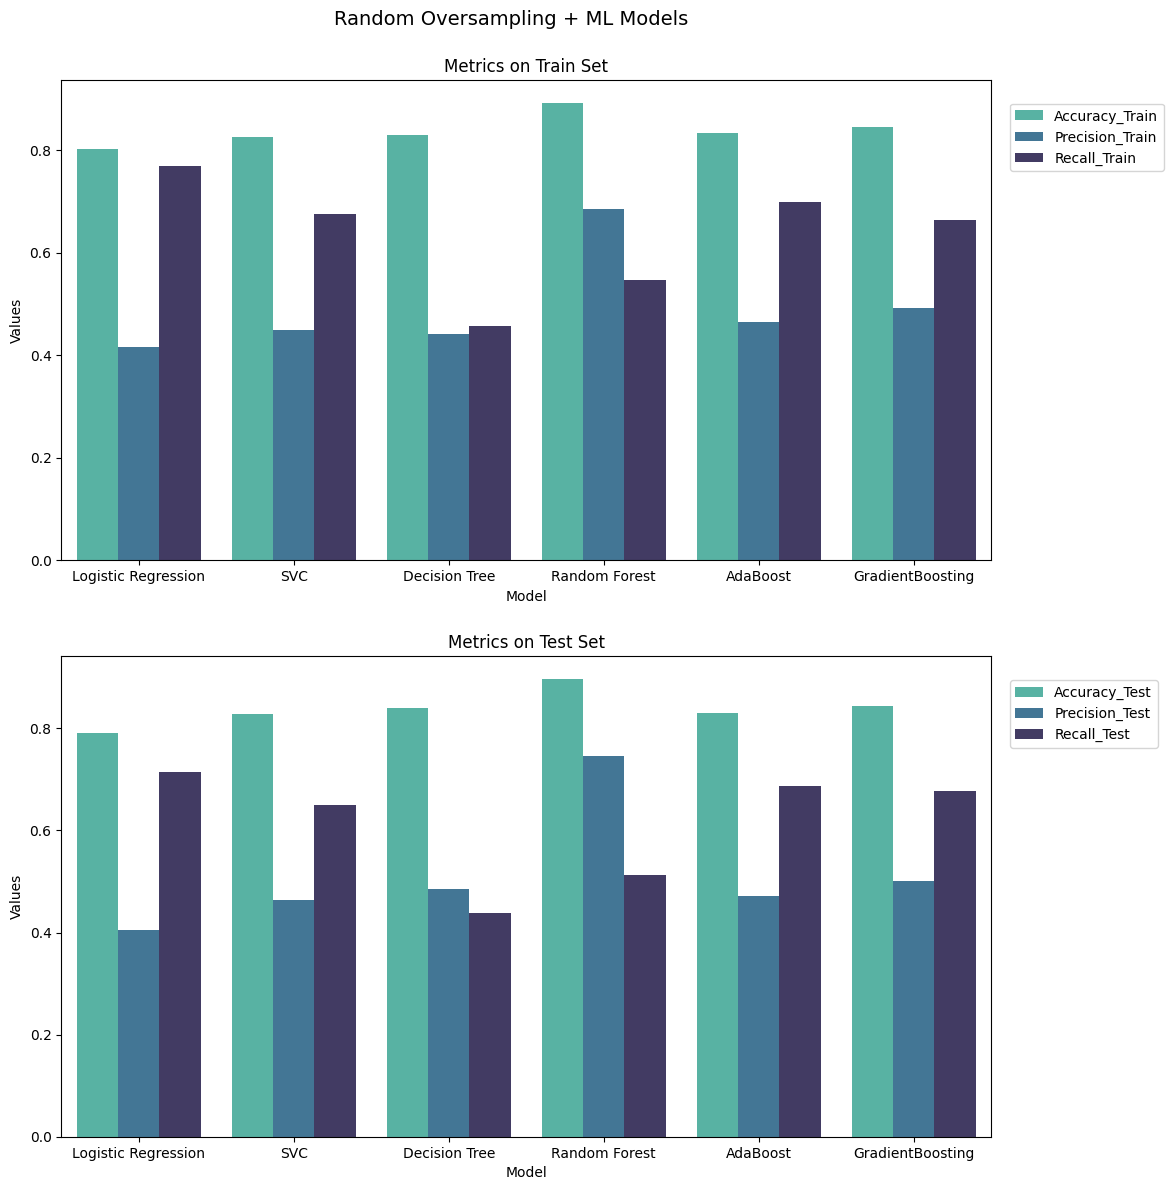

In [26]:
# Plot metrics obtained for Train set and Test set
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 14), dpi=100)
fig.suptitle('Random Oversampling + ML Models', fontsize=14, y=0.93)
sns.barplot(data=metrics_melt_rand_train, x='Model', y='value', hue='variable', palette='mako_r', ax=ax1)
sns.barplot(data=metrics_melt_rand_test, x='Model', y='value', hue='variable', palette='mako_r', ax=ax2)

ax1.set_ylabel('Values')
ax1.set_title('Metrics on Train Set')
ax1.legend(loc=(1.02, 0.81))

ax2.set_ylabel('Values')
ax2.set_title('Metrics on Test Set')
ax2.legend(loc=(1.02, 0.81));

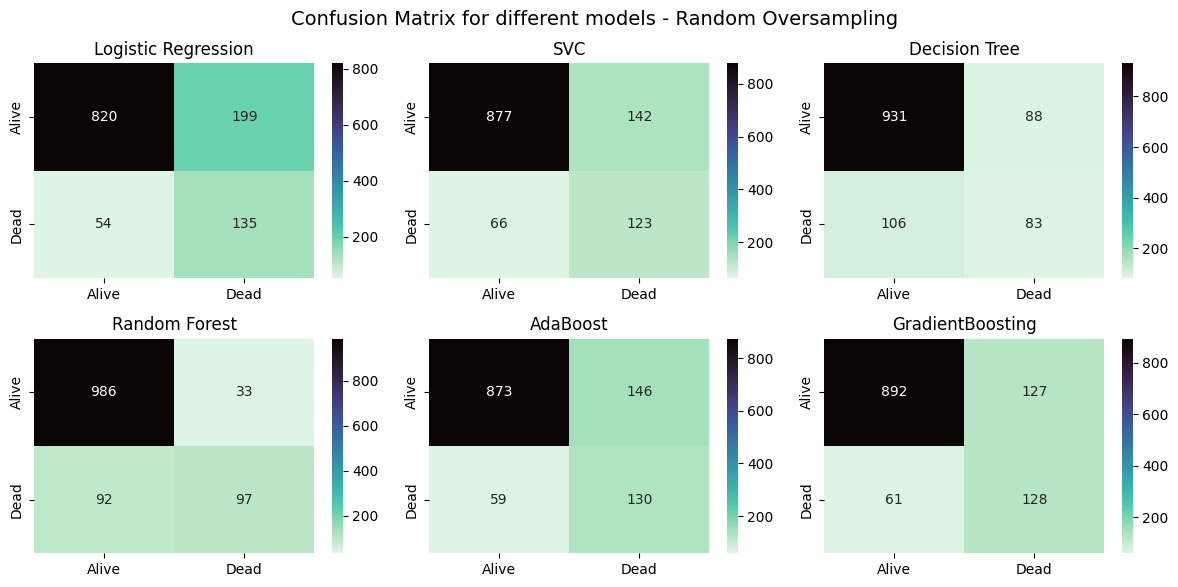

In [27]:
# Display confusion matrix for models + random oversampling
plot_confusion_matrix(cls_models, y_test, y_pred_list_rand, 'Random Oversampling', 2, 3, 12, 6)

* For the random oversampling case, though the accuracy scores on the train and test sets are above 0.80 for all the models, there is a small increase in recall score with a significant drop in precision score compared to the baseline case.  


* We aim to increase the prediction of the 'True Positive' class (i.e. `Dead` class). With the random oversampling approach, the prediction of the `Dead` class is slightly improved for Logistic Regression, Support Vector Classifier, AdaBoost Classifier, and Gradient Boosting but worse for Decision Tree and Random Forest Classifiers. 


* Now we will use SMOTE approach for balancing the dataset and then predict the target label. 


**SMOTE:** Synthetic Minority Oversampling Technique (SMOTE), an oversampling algorithm, creates new synthetic points which provide new information to the machine learning models.

In [28]:
# SMOTE Method

accuracy_train = []
precision_train = []
recall_train = []

accuracy_test = []
precision_test = []
recall_test = []

y_pred_list_smote = []

method = 'SMOTE'

# Train model
for name, model in cls_models.items():
    run_sampling_model(model, method)

# Store metrics in a dataframe
metrics_smote_train = pd.DataFrame(list(zip(cls_models.keys(), accuracy_train, 
                                           precision_train, recall_train)), 
                                  columns=['Model', 'Accuracy_Train', 'Precision_Train', 'Recall_Train'])


metrics_smote_test = pd.DataFrame(list(zip(cls_models.keys(), accuracy_test, 
                                           precision_test, recall_test)), 
                                  columns=['Model', 'Accuracy_Test', 'Precision_Test', 'Recall_Test'])

metrics_melt_smote_train = pd.melt(metrics_smote_train, id_vars=['Model'], 
                                  value_vars=['Accuracy_Train', 'Precision_Train', 'Recall_Train'])

metrics_melt_smote_test = pd.melt(metrics_smote_test, id_vars=['Model'], 
                                 value_vars=['Accuracy_Test', 'Precision_Test', 'Recall_Test'])

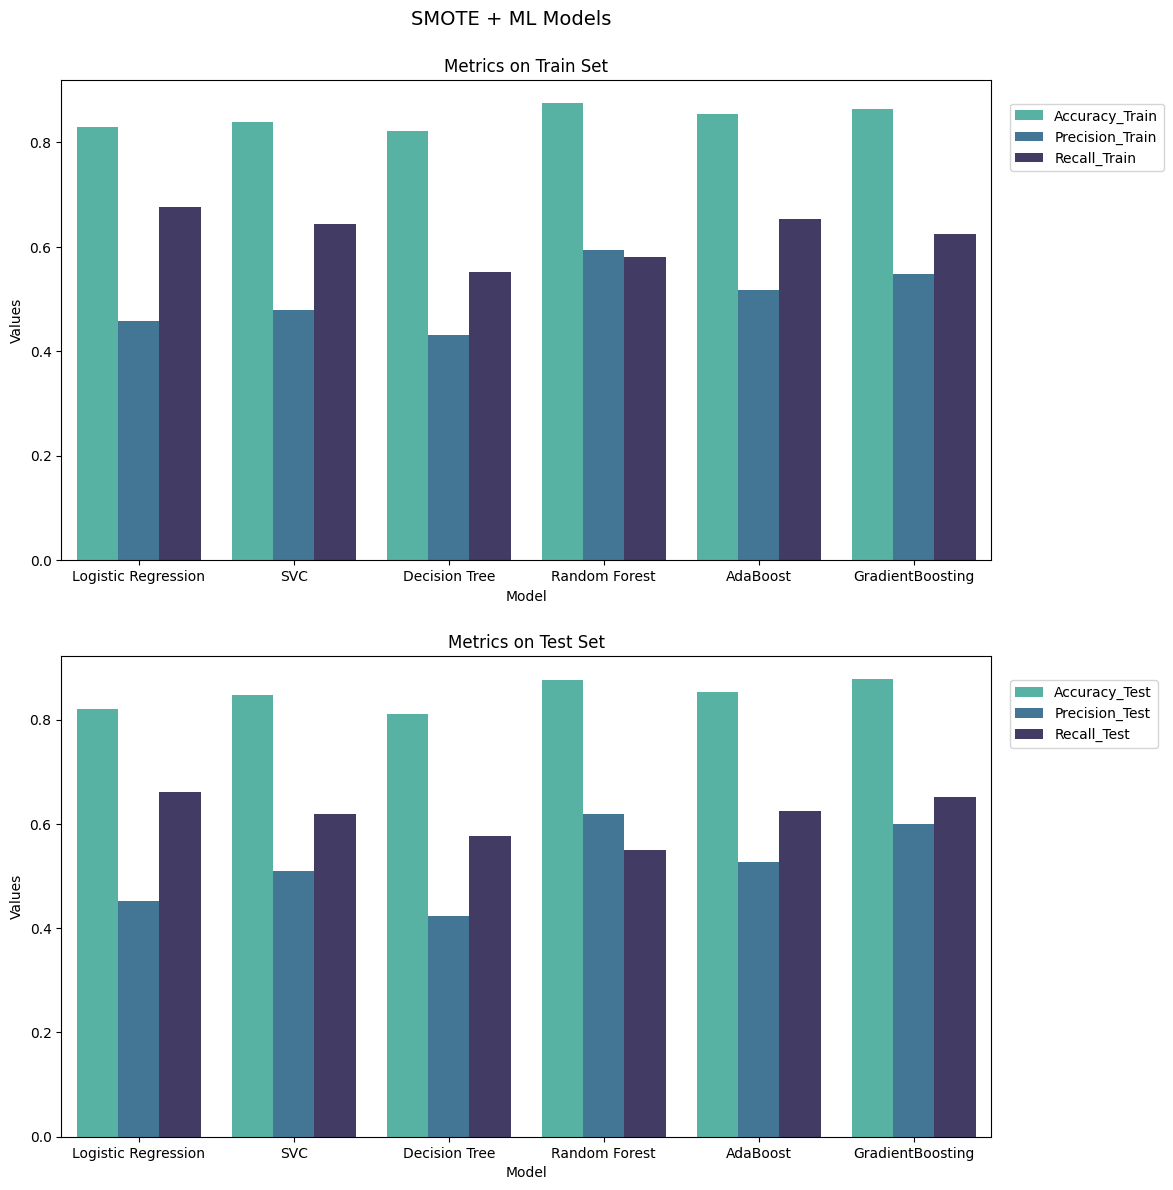

In [29]:
# Plot metrics
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 14), dpi=100)
fig.suptitle('SMOTE + ML Models', fontsize=14, y=0.93)
sns.barplot(data=metrics_melt_smote_train, x='Model', y='value', hue='variable', palette='mako_r', ax=ax1)
sns.barplot(data=metrics_melt_smote_test, x='Model', y='value', hue='variable', palette='mako_r', ax=ax2)

ax1.set_ylabel('Values')
ax1.set_title('Metrics on Train Set')
ax1.legend(loc=(1.02, 0.81))

ax2.set_ylabel('Values')
ax2.set_title('Metrics on Test Set')
ax2.legend(loc=(1.02, 0.81));

* The accuracy, precision, and recall scores for the train and test sets for SMOTE approach are displayed with the bar plots. On the train and test sets, SMOTE approach with ML models provides almost the same accuracy as the random oversampling approach did. But the prediction of the `Dead` class is improved considerably with a slight drop in precision scores. 


* As there is always a tug-of-war between precision and recall scores, an increase in the recall score will affect the precision score. 


* With the SMOTE approach, Random Forest, AdaBoost, and Gradient Boosting Classifiers performed well in precision and recall scores compared to the baseline models. However, the Logistic Regression and Support Vector Classifier models had the highest recall scores, but did not accurately predict the "Alive" class. This is due to an increase in the number of "false positive" predictions, which occurred when the models wrongly classified a patient as dead even though they were actually alive.



* The decision tree model performs poorly on the train set as well as the test set for both random oversampling and SMOTE methods. 


* Based on the good precision and recall scores of the Random Forest, AdaBoost, and Gradient Boosting Classifiers on the train and test sets when using the SMOTE approach, we will further analyze these models by conducting a grid search with the SMOTE approach applied. This will involve adjusting various hyperparameters for the Random Forest, AdaBoost, and Gradient Boosting models to see if we can improve their performance.

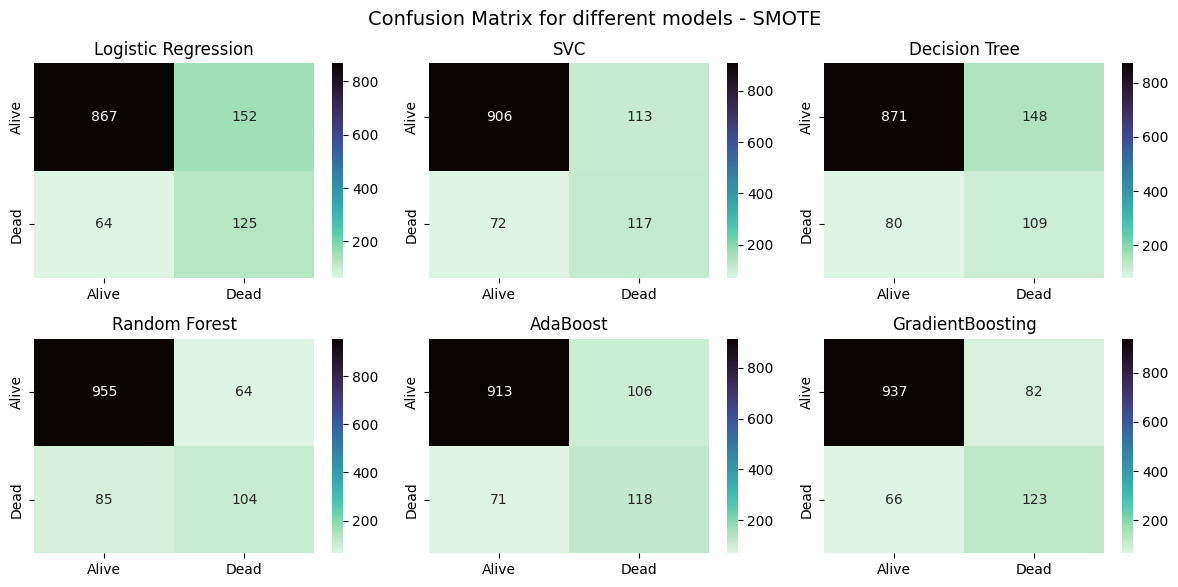

In [30]:
# Confusion matrix for different models when using SMOTE method for balancing the dataset
plot_confusion_matrix(cls_models, y_test, y_pred_list_smote, 'SMOTE', 2, 3, 12, 6)

## SMOTE + GridSearchCV - 3 Models

In [31]:
# Function for performing the gridsearch for SMOTE applied dataset
def run_sampling_grid(estimator):
    
    cv = kfold
    
    accuracy_list = []
    recall_list = []
    precision_list = []
    
    sampling_params = {'sampling_strategy' : 'auto', 'random_state' : seed}
    
    rand_over = SMOTE(**sampling_params)
        
    for train, val in cv.split(X_train, y_train):
        pipeline = make_pipeline(rand_over, estimator)
        model = pipeline.fit(X_train.iloc[train], y_train.iloc[train])
        model_best = estimator.best_estimator_
        y_val_predict = model_best.predict(X_train.iloc[val])

        recall_list.append(pipeline.score(X_train.iloc[val], y_train.iloc[val]))
        accuracy_list.append(accuracy_score(y_train.iloc[val], y_val_predict))
        precision_list.append(precision_score(y_train.iloc[val], y_val_predict))
        
    
    mean_accuracy_train = np.mean(accuracy_list)
    mean_precision_train = np.mean(precision_list)
    mean_recall_train = np.mean(recall_list)
    
    accuracy_gtrain.append(mean_accuracy_train)
    precision_gtrain.append(mean_precision_train)
    recall_gtrain.append(mean_recall_train)
    
    # Predict target
    y_predict = model_best.predict(X_test)
    y_pred_list_grid.append(y_predict)
    best_params.append(estimator.best_params_)
    
    # Performance Metrics
    accuracy_pred = accuracy_score(y_test, y_predict)
    precision_pred = precision_score(y_test, y_predict)
    recall_pred = recall_score(y_test, y_predict)
    
    accuracy_gtest.append(accuracy_pred)
    precision_gtest.append(precision_pred)
    recall_gtest.append(recall_pred)
    

In [32]:
# GridSearchCV - Three ML Models (Random Forest, AdaBoost and Gradient Boosting Methods)

accuracy_gtrain = []
precision_gtrain = []
recall_gtrain = []

accuracy_gtest = []
precision_gtest = []
recall_gtest = []

y_pred_list_grid = []

score = 'recall'

grid_models = ['Random Forest Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier']

# Random Forest Parameters
param_rfc = {'n_estimators' : np.arange(50, 300, 25), 'criterion' : ['gini', 'entropy'], 
             'max_features' : ['sqrt', 'log2'], 'min_samples_leaf' : [1, 2, 4, 5], 
             'bootstrap' : [True, False]}

grid_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=seed), 
                        param_grid=param_rfc, scoring=score, n_jobs=-1)

# AdaBoost Parameters
param_ada = {'base_estimator' : [DecisionTreeClassifier(), RandomForestClassifier()], 
             'n_estimators' : np.arange(50, 350, 25), 
             'learning_rate' : np.arange(0.2, 2.2, 0.2)}

grid_ada = GridSearchCV(estimator=AdaBoostClassifier(random_state=seed), 
                        param_grid=param_ada, scoring=score, n_jobs=-1)

# Gradient Boosting Parameters
param_grb = {'n_estimators' : np.arange(50, 200, 25), 'learning_rate' : np.arange(0.2, 2.0, 0.2),
             'max_depth' : np.arange(3, 7)}

grid_grb = GridSearchCV(estimator=GradientBoostingClassifier(random_state=seed), 
                        param_grid=param_grb, scoring=score, n_jobs=-1)

grid_cv = [grid_rfc, grid_ada, grid_grb]

best_params = []

for model in grid_cv:
    run_sampling_grid(model)

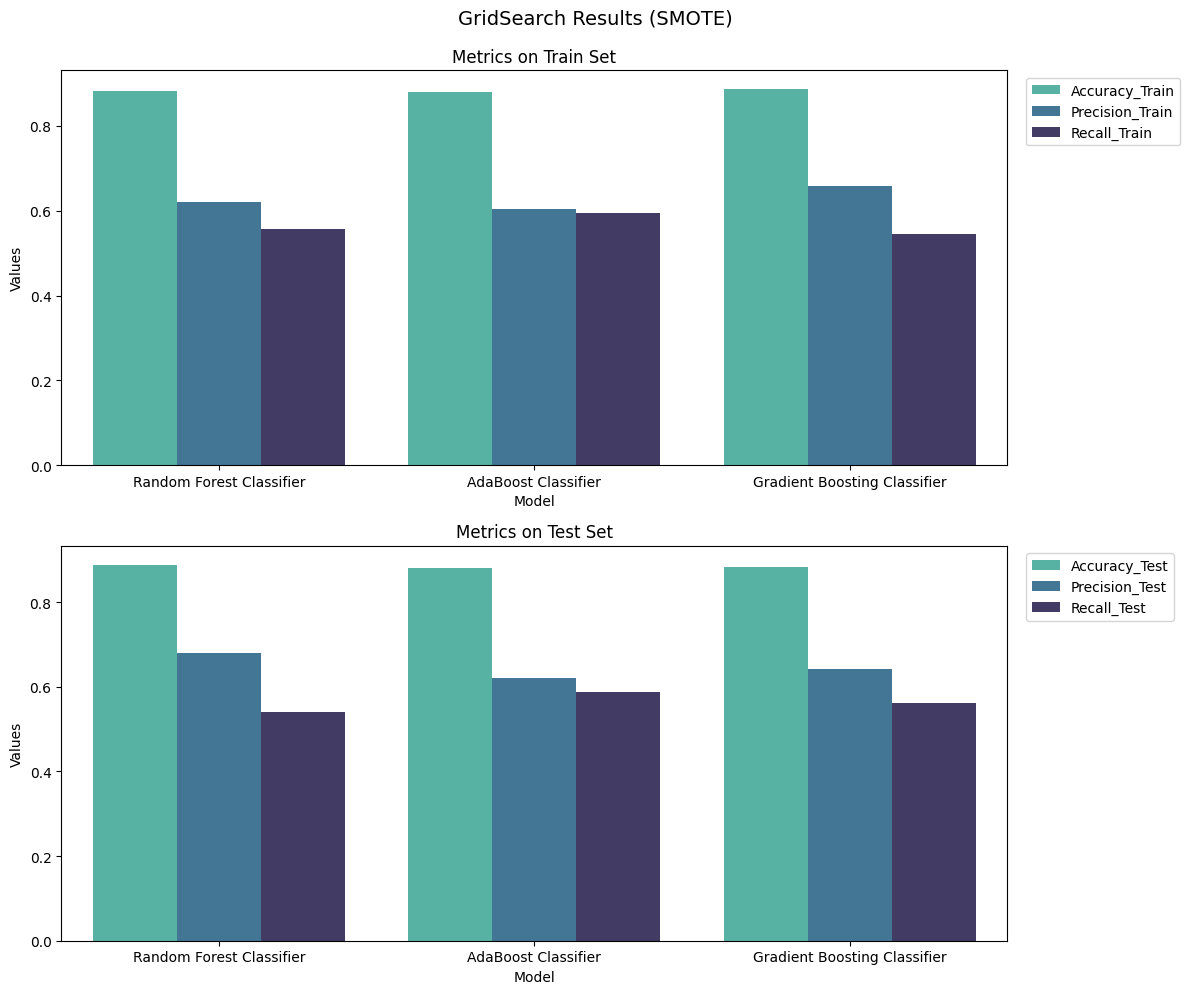

In [33]:
metrics_grid_train = pd.DataFrame(list(zip(grid_models, accuracy_gtrain, 
                                           precision_gtrain, recall_gtrain)), 
                                  columns=['Model', 'Accuracy_Train', 'Precision_Train', 'Recall_Train'])

metrics_grid_test = pd.DataFrame(list(zip(grid_models, accuracy_gtest, 
                                           precision_gtest, recall_gtest)), 
                                  columns=['Model', 'Accuracy_Test', 'Precision_Test', 'Recall_Test'])

metrics_melt_grid_train = pd.melt(metrics_grid_train, id_vars=['Model'], 
                                  value_vars=['Accuracy_Train', 'Precision_Train', 'Recall_Train'])

metrics_melt_grid_test = pd.melt(metrics_grid_test, id_vars=['Model'], 
                                 value_vars=['Accuracy_Test', 'Precision_Test', 'Recall_Test'])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=100)
fig.suptitle('GridSearch Results (SMOTE)', fontsize=14, y=0.99)
sns.barplot(data=metrics_melt_grid_train, x='Model', y='value', hue='variable', palette='mako_r', ax=ax1)
sns.barplot(data=metrics_melt_grid_test, x='Model', y='value', hue='variable', palette='mako_r', ax=ax2)


ax1.set_ylabel('Values')
ax1.set_title('Metrics on Train Set')
ax1.legend(loc=(1.02, 0.81))

ax2.set_ylabel('Values')
ax2.set_title('Metrics on Test Set')
ax2.legend(loc=(1.02, 0.81))

plt.tight_layout();

After tuning hyperparameters for the three models, the precision and recall scores are somewhat around 0.60 with accuracy scores around 0.85. For the best hyperparameters, the models did not improve the `Dead` class prediction compared to the previous case without grid search. However, the "false positive" predictions for the `Alive` class are greatly reduced. This can be visualized in the confusion matrix shown below.

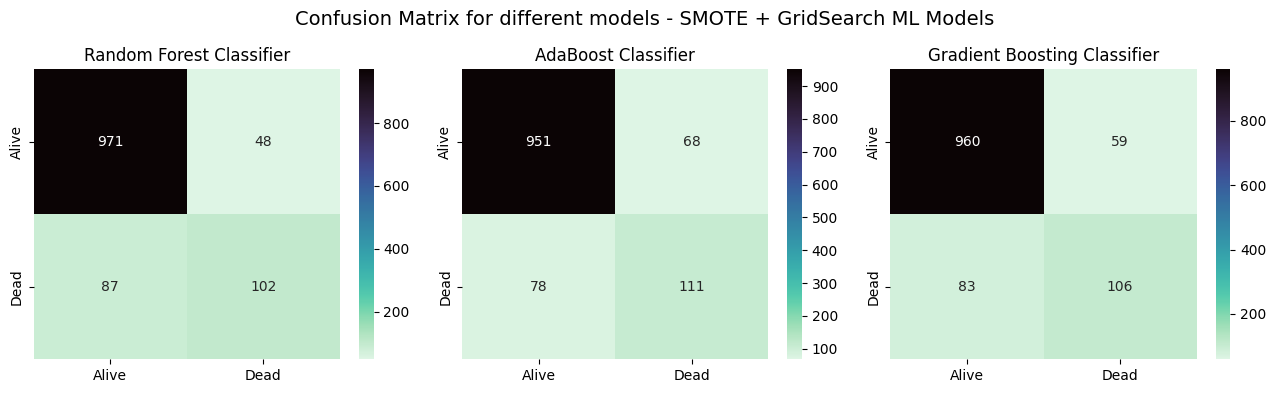

In [34]:
plot_confusion_matrix(grid_models, y_test, y_pred_list_grid, 'SMOTE + GridSearch ML Models', 1, 3, 13, 4)

# 5. Conclusion

* We performed data analysis and applied several machine learning models to the breast cancer dataset in order to predict patient survival. The data set was imbalanced, so we used the random oversampling and SMOTE techniques to oversample the minority class. 


* For the baseline problem with imbalanced dataset, the predictions were biased towards the majority class. With random oversampling and SMOTE techniques, the dataset was balanced by increasing the observations belonging to the minority class. 


* The random oversampling approach of balancing the dataset did not lead the models to correctly predict the minority class.


* For the SMOTE approach, after training and evaluating the models, we found that the Random Forest, AdaBoost, and Gradient Boosting Classifiers all performed well in terms of precision and recall scores compared to other models and oversampling approach. However, the Logistic Regression and Support Vector Classifier models, which had the highest recall scores, did not perform as well at predicting the 'Alive' class correctly. This is because the 'False Positive' value, which represents the number of times the model incorrectly predicted that a patient was dead, was particularly high for these models. 


* We attempted to improve the performance of the Random Forest, AdaBoost, and Gradient Boosting models by trying different hyperparameter settings. While this slightly improved the ability of the models to correctly predict the "True Negative" class (i.e., patients who are alive), it did not result in an increase in recall scores. 


* We also tried testing the models on both imbalanced and balanced datasets using two different approaches (random oversampling and SMOTE). However, the final results were not satisfactory. One potential reason for this is that there was no strong correlation between the features in the data set and the target label, and some important features, such as "Metastasis," were missing from the data set. The performance metrics also showed that these oversampling approaches did not always improve the predictions. 


* To improve the performance of the models, we may need to add more features to the dataset, find more observations for the minority class, or try a different model.

# 6. References

1. [SEER Breast Cancer Data](https://ieee-dataport.org/open-access/seer-breast-cancer-data)


2. [Credit Fraud || Dealing with Imbalanced Datasets](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)


3. [Outlier detection methods!](https://www.kaggle.com/code/marcinrutecki/outlier-detection-methods)



4. [An opinionated guide to imbalanced classes](https://colab.research.google.com/gist/artificialsoph/6906ff7ca66531a6c660a0cc24355ff4/an-opinionated-guide-to-imbalanced-classes.ipynb#scrollTo=sCfQkH6nmOfY)